<h1><center>Shopper Profile</center></h1>

* Bu notebook Traditional Channel'da İstanbuldaki shopper profile'ları bulmak için hier. clustering'in kullanıldığı bir çalışmadır. 
* Bir öncekinden farkı hier. clusteringden sonra en yüksek sayıda outlet içeren cluster'ı 2. bir clustering yaparak ayırma işlemi içerir.


In [1]:
# Database Connection
from google.cloud import bigquery, bigquery_storage_v1beta1

# basic
import os
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Model
import sklearn
from scipy.special import boxcox1p
from scipy import stats
from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation, Birch, MeanShift, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.ensemble import IsolationForest
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering

sns.set_style("whitegrid")
# sns.color_palette('bright')
sns.set_palette('dark')

In [2]:
bq_client = bigquery.Client()
bq_storage_client = bigquery_storage_v1beta1.BigQueryStorageClient()

sql = """
with rb_sales_tr as (
select sls.OutletNumber, 
        SUM(CASE when art.ArticleBrandCode = 'H' THEN UcSales ELSE 0 END) as burn_rb200,
        SUM(CASE when art.ArticleBrandCode = 'P' THEN UcSales ELSE 0 END) as cappy_rb200,
        SUM(CASE when art.ArticleBrandCode = 'L' THEN UcSales ELSE 0 END) as cc_light_rb200,
        SUM(CASE when art.ArticleBrandCode = 'C' THEN UcSales ELSE 0 END) as cc_rb200,
        SUM(CASE when art.ArticleBrandCode = 'DM' THEN UcSales ELSE 0 END) as damla_minera_rb200,
        SUM(CASE when art.ArticleBrandCode = 'D' THEN UcSales ELSE 0 END) as damla_water_rb200,
        SUM(CASE when art.ArticleBrandCode = 'EX' THEN UcSales ELSE 0 END) as exotic_rb200,
        SUM(CASE when art.ArticleBrandCode = 'F' THEN UcSales ELSE 0 END) as fanta_rb200,
        SUM(CASE when art.ArticleBrandCode = 'FT' THEN UcSales ELSE 0 END) as fusetea_rb200,
        SUM(CASE when art.ArticleBrandCode = 'MN' THEN UcSales ELSE 0 END) as monster_rb200,
        SUM(CASE when art.ArticleBrandCode = 'E' THEN UcSales ELSE 0 END) as powerade_rb200,
        SUM(CASE when art.ArticleBrandCode = 'S' THEN UcSales ELSE 0 END) as schweppes_rb200,
        SUM(CASE when art.ArticleBrandCode = 'G' THEN UcSales ELSE 0 END) as sprite_rb200
  from `coca-cola-data-lake.SALES.vt_fct_sales` sls
  join `coca-cola-data-lake.ARTICLE.vt_dim_article` as art 
    on (sls.ArticleNumber = art.ArticleNumber and sls.CountryCode = art.CountryCode)  
  join `coca-cola-data-lake.ARTICLE.vt_dim_article_package_group_text` art_gr
    on (art.ArticlePackageGroupCode = art_gr.article_package_group_code and	art_gr.language_code = 'ENG')
  join `coca-cola-data-lake.ARTICLE.vt_dim_article_package_size_text` art_sz
    on (art.ArticlePackageSizeCode = art_sz.article_package_size_code and art_sz.language_code = 'ENG')
where sls.InvoiceStatusCode = 'OK'
  and sls.SalesTypeCode in ('C2', 'C3', 'C5', 'D1')
  and sls.ArticleMixFlag in ('0','1')
  and sls.PhcSales > 0
  and sls.CalendarDay >= '2021-01-01'
  and sls.CalendarDay <= '2021-12-31'
-- and art.GenericArticleNumber = 1000 
  and art_gr.article_package_group_text = 'Rb'
  and art_sz.article_package_size_code = '1'
  and sls.CountryCode = 'TR'
group by sls.OutletNumber 
)
select *
from coca-cola-datalake-dev.DEV_EEMIRALI.SHOPPER_PROFILE as shopper
left join rb_sales_tr 
  on (rb_sales_tr.OutletNumber = shopper.outlet_number) 
"""

df = bq_client.query(sql, location='EU').to_dataframe(bqstorage_client = bq_storage_client, progress_bar_type='tqdm')

Downloading:   0%|          | 0/290255 [00:00<?, ?rows/s]/opt/conda/lib/python3.7/site-packages/pyarrow/util.py:39: FutureWarning: pyarrow.read_schema is deprecated as of 0.17.0, please use pyarrow.ipc.read_schema instead
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/pyarrow/util.py:39: FutureWarning: pyarrow.read_record_batch is deprecated as of 0.17.0, please use pyarrow.ipc.read_record_batch instead
  warnings.warn(msg, FutureWarning)
Downloading: 100%|██████████| 290255/290255 [00:05<00:00, 54386.40rows/s]


In [3]:
df.head()

,outlet_number,outlet_name,GEOGPOINT,IDARIID,MAIN_CHANNEL,SEGMENT,SES,YAS_CLUSTER,ILADI,ILCEADI,...,cc_rb200,damla_minera_rb200,damla_water_rb200,exotic_rb200,fanta_rb200,fusetea_rb200,monster_rb200,powerade_rb200,schweppes_rb200,sprite_rb200
0,7158909,DOGAN TEKEL,POINT(29.06616217 40.18558327),22528,TRADITIONAL RETAIL,SILVER,C1,SIFIR,Bursa,Osmangazi,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9082733,KARDESLER PIDE,POINT(29.06576674 40.18505304),22528,ON-PREMISE,GOLD,C1,SIFIR,Bursa,Osmangazi,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8921197,PARALI BUFE,POINT(29.0647642900001 40.18573423),22528,ON-PREMISE,SILVER,C1,SIFIR,Bursa,Osmangazi,...,135.20,0.0,0.0,0.0,16.055,0.0,0.0,0.0,0.0,0.000
3,9521421,SARDUNYA APERATIF,POINT(29.0661958605052 40.1850513461977),22528,ON-PREMISE,SILVER,C1,SIFIR,Bursa,Osmangazi,...,256.88,0.0,0.0,0.0,6.760,0.0,0.0,0.0,0.0,2.535
4,7173090,DAVUT BIRLES,POINT(29.06531874 40.1851168),22528,ON-PREMISE,BRONZE,C1,SIFIR,Bursa,Osmangazi,...,25.35,0.0,0.0,0.0,5.915,0.0,0.0,0.0,0.0,0.000


## EDA

In [4]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290255 entries, 0 to 290254
Columns: 127 entries, outlet_number to sprite_rb200
dtypes: float64(111), int64(6), object(10)
memory usage: 281.2+ MB


In [5]:
df.MAIN_CHANNEL.unique()

array(['TRADITIONAL RETAIL', 'ON-PREMISE', 'MODERN RETAIL', 'E-COMMERCE',
       'OTHER/THIRD PARTY', 'DISCOUNTER'], dtype=object)

In [6]:
df.outlet_number.nunique()

290255

In [7]:
df['outlet_number'] = df['outlet_number'].astype(object)

In [8]:
df = df.query("ILADI == 'İstanbul'").reset_index(drop=True)

In [9]:
df = df.query("MAIN_CHANNEL == 'TRADITIONAL RETAIL'").reset_index(drop=True)

In [10]:
# Bu dataframe üstünde oynama yapılmamış ana datadır.
df.outlet_number.nunique()

23978

In [11]:
# bu dataframe, model için kullanılacak dataframe'dir
model_data = df.copy()

In [12]:
model_data = model_data[[      
"SES"           
,"YAS_CLUSTER"
,"HANE_BUYUKLUGU"
,"ZENGINLIK_INDEKSI"
,"AYLIK_HARCAMA"   
,'SEGMENT'
,'GIDAVEICECEK'
,'ALKOLTUTUN'
,'EGLENCEKULTUR'
,'LOKANTAOTEL'
,'GIDAVEICECEK_ORAN'
,'ALKOLTUTUN_ORAN'
,'EGLENCEKULTUR_ORAN'
,'LOKANTAOTEL_ORAN'
]]

In [13]:
model_data

,SES,YAS_CLUSTER,HANE_BUYUKLUGU,ZENGINLIK_INDEKSI,AYLIK_HARCAMA,SEGMENT,GIDAVEICECEK,ALKOLTUTUN,EGLENCEKULTUR,LOKANTAOTEL,GIDAVEICECEK_ORAN,ALKOLTUTUN_ORAN,EGLENCEKULTUR_ORAN,LOKANTAOTEL_ORAN
0,C1,SIFIR,1.363636,3.633539,6481,SILVER PLUS,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0
1,D,SIFIR,1.195455,1.490437,2331,BRONZE,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0
2,D,SIFIR,1.195455,1.490437,2331,SILVER,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0
3,D,SIFIR,1.195455,1.490437,2331,SILVER PLUS,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0
4,D,SIFIR,1.195455,1.490437,2331,GOLD,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23973,D,OLD,1.234416,0.550000,1414,SILVER PLUS,294.112,65.044,29.694,86.254,20.8,4.6,2.1,6.1
23974,D,OLD,1.234416,0.550000,1414,SILVER,294.112,65.044,29.694,86.254,20.8,4.6,2.1,6.1
23975,D,OLD,1.234416,0.550000,1414,SILVER PLUS,294.112,65.044,29.694,86.254,20.8,4.6,2.1,6.1
23976,D,OLD,1.234416,0.550000,1414,SILVER,294.112,65.044,29.694,86.254,20.8,4.6,2.1,6.1


In [14]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23978 entries, 0 to 23977
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SES                 23978 non-null  object 
 1   YAS_CLUSTER         23978 non-null  object 
 2   HANE_BUYUKLUGU      23978 non-null  float64
 3   ZENGINLIK_INDEKSI   23978 non-null  float64
 4   AYLIK_HARCAMA       23978 non-null  int64  
 5   SEGMENT             23978 non-null  object 
 6   GIDAVEICECEK        23978 non-null  float64
 7   ALKOLTUTUN          23978 non-null  float64
 8   EGLENCEKULTUR       23978 non-null  float64
 9   LOKANTAOTEL         23978 non-null  float64
 10  GIDAVEICECEK_ORAN   23978 non-null  float64
 11  ALKOLTUTUN_ORAN     23978 non-null  float64
 12  EGLENCEKULTUR_ORAN  23978 non-null  float64
 13  LOKANTAOTEL_ORAN    23978 non-null  float64
dtypes: float64(10), int64(1), object(3)
memory usage: 2.6+ MB


In [15]:
# Get one label encoding of column "SES"
model_data["SES"] = model_data["SES"].replace({'A': 6, 'B': 5, 'C1': 4, 'C2': 3, 'D': 2, 'E': 1})

In [16]:
# Get one label encoding of column "YAS_CLUSTER"
model_data["YAS_CLUSTER"] = model_data["YAS_CLUSTER"].replace({'SIFIR': 1, 'TEEN': 2, 'YOUNG': 3, 'YOUNG ADULT': 4, 'ADULT': 5, 'MIDDLE AGED': 6, 'OLD': 7})

In [17]:
# Get one label encoding of column "SEGMENT"
model_data["SEGMENT"] = model_data["SEGMENT"].replace({'BRONZE': 1, 'SILVER': 2, 'SILVER PLUS': 3, 'GOLD': 4})

In [18]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23978 entries, 0 to 23977
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SES                 23978 non-null  int64  
 1   YAS_CLUSTER         23978 non-null  int64  
 2   HANE_BUYUKLUGU      23978 non-null  float64
 3   ZENGINLIK_INDEKSI   23978 non-null  float64
 4   AYLIK_HARCAMA       23978 non-null  int64  
 5   SEGMENT             23978 non-null  int64  
 6   GIDAVEICECEK        23978 non-null  float64
 7   ALKOLTUTUN          23978 non-null  float64
 8   EGLENCEKULTUR       23978 non-null  float64
 9   LOKANTAOTEL         23978 non-null  float64
 10  GIDAVEICECEK_ORAN   23978 non-null  float64
 11  ALKOLTUTUN_ORAN     23978 non-null  float64
 12  EGLENCEKULTUR_ORAN  23978 non-null  float64
 13  LOKANTAOTEL_ORAN    23978 non-null  float64
dtypes: float64(10), int64(4)
memory usage: 2.6 MB


#### Scaling and Normal Dist.

In [19]:
model_df = model_data.copy()

In [20]:
model_data = model_data.replace(np.nan,0)

In [21]:
model_data.clip(lower=0, inplace=True)

In [22]:
model_data.replace({0: 0.00001}, inplace=True)

In [23]:
# define a method to scale data, looping thru the columns, and passing a scaler
def scale_data(data):
    min_max_scaler = preprocessing.MinMaxScaler()
    for col in data.columns:
        data[col] = min_max_scaler.fit_transform(data[col].values.reshape(-1, 1))
    return data

In [24]:
def normal_dist(data):
    for col in data.columns:
        data[col] = data[col].apply(lambda x: boxcox1p(x,0.25))
        stats.boxcox(data[col])[0]
    return data

In [25]:
# Normal Dist.
model_df["SES"] = stats.boxcox(model_data["SES"])[0]
model_df["YAS_CLUSTER"] = stats.boxcox(model_data["YAS_CLUSTER"])[0]
model_df["HANE_BUYUKLUGU"] = stats.boxcox(model_data["HANE_BUYUKLUGU"])[0]      
model_df["ZENGINLIK_INDEKSI"] = stats.boxcox(model_data["ZENGINLIK_INDEKSI"])[0]   
model_df["AYLIK_HARCAMA"] = stats.boxcox(model_data["AYLIK_HARCAMA"])[0]   
model_df["SEGMENT"] = stats.boxcox(model_data["SEGMENT"])[0] 
model_df["GIDAVEICECEK"] = stats.boxcox(model_data["GIDAVEICECEK"])[0]   
model_df["ALKOLTUTUN"] = stats.boxcox(model_data["ALKOLTUTUN"])[0]   
model_df["EGLENCEKULTUR"] = stats.boxcox(model_data["EGLENCEKULTUR"])[0]  
model_df["LOKANTAOTEL"] = stats.boxcox(model_data["LOKANTAOTEL"])[0]    
model_df["GIDAVEICECEK_ORAN"] = stats.boxcox(model_data["GIDAVEICECEK_ORAN"])[0]  
model_df["ALKOLTUTUN_ORAN"] = stats.boxcox(model_data["ALKOLTUTUN_ORAN"])[0]     
model_df["EGLENCEKULTUR_ORAN"] = stats.boxcox(model_data["EGLENCEKULTUR_ORAN"])[0]  
model_df["LOKANTAOTEL_ORAN"] = stats.boxcox(model_data["LOKANTAOTEL_ORAN"])[0]                               

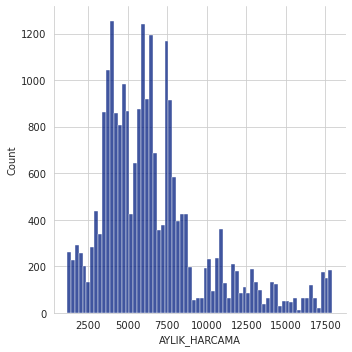

In [26]:
# original value
sns.displot(model_data["AYLIK_HARCAMA"])

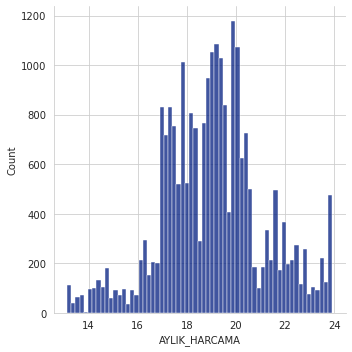

In [27]:
# original to normal dist. 
sns.displot(model_df["AYLIK_HARCAMA"])

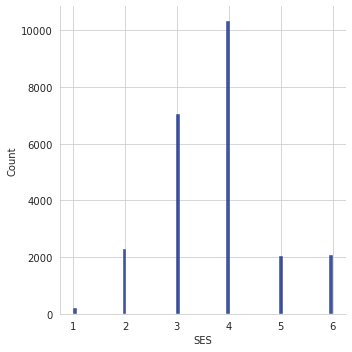

In [28]:
# normal dist. to scaling
sns.displot(model_data["SES"])

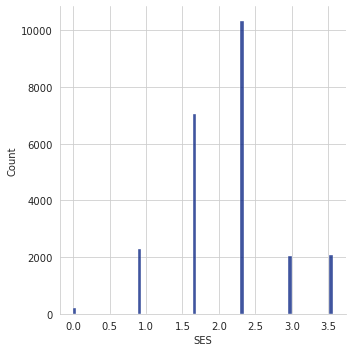

In [29]:
# normal dist. to scaling
sns.displot(model_df["SES"])

#### Scaling Part

In [30]:
model_df = scale_data(model_df)

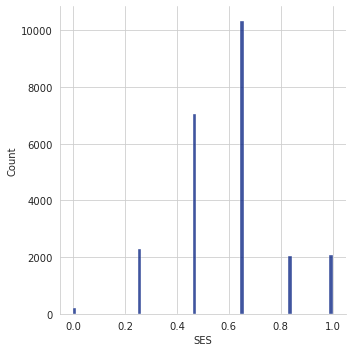

In [31]:
sns.displot(model_df['SES'])

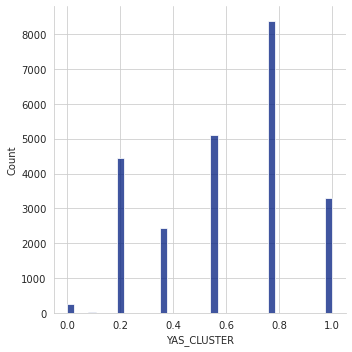

In [32]:
sns.displot(model_df['YAS_CLUSTER'])

In [33]:
# final data for model
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23978 entries, 0 to 23977
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SES                 23978 non-null  float64
 1   YAS_CLUSTER         23978 non-null  float64
 2   HANE_BUYUKLUGU      23978 non-null  float64
 3   ZENGINLIK_INDEKSI   23978 non-null  float64
 4   AYLIK_HARCAMA       23978 non-null  float64
 5   SEGMENT             23978 non-null  float64
 6   GIDAVEICECEK        23978 non-null  float64
 7   ALKOLTUTUN          23978 non-null  float64
 8   EGLENCEKULTUR       23978 non-null  float64
 9   LOKANTAOTEL         23978 non-null  float64
 10  GIDAVEICECEK_ORAN   23978 non-null  float64
 11  ALKOLTUTUN_ORAN     23978 non-null  float64
 12  EGLENCEKULTUR_ORAN  23978 non-null  float64
 13  LOKANTAOTEL_ORAN    23978 non-null  float64
dtypes: float64(14)
memory usage: 2.6 MB


### Feature Weighting

In [34]:
# Modele koymadan önce feature'ları ağırlıklandıralım.      
model_df["SES"] = model_df["SES"] *  5         
model_df["YAS_CLUSTER"] = model_df["YAS_CLUSTER"] *  5
#model_df["LOKANTAOTEL_ORAN"] = model_df["LOKANTAOTEL_ORAN"] * 0.5

# model_df["ORTA_UST"] = model_df["ORTA_UST"] * 1.2
# model_df["ZENGINLIK_INDEKSI"] = model_df["ZENGINLIK_INDEKSI"] * 1.2   
# model_df["AYLIK_HARCAMA"] = model_df["AYLIK_HARCAMA"] * 1.2  
#model_df["HANE_BUYUKLUGU"] = model_df["HANE_BUYUKLUGU"] * 10
#model_df["ALKOLTUTUN_ORAN"] = model_df["ALKOLTUTUN_ORAN"] * 30    
#model_df["EGLENCEKULTUR_ORAN"] = model_df["EGLENCEKULTUR_ORAN"] * 0.5 
#model_df["KULTUREL"] = model_df["KULTUREL"] * 10
#model_df["UNIVERSITE"] = model_df["UNIVERSITE"] * 10
#model_df["EGITIM"] = model_df["EGITIM"] * 10  

## Model

In [ ]:
hrc_model = AgglomerativeClustering(n_clusters=5, linkage='ward', affinity='euclidean')
hrc_preds = hrc_model.fit_predict(model_df)

In [ ]:
model_df["hrc_cluster"] = hrc_preds

In [ ]:
df["hrc_cluster"] = hrc_preds

In [ ]:
model_df["hrc_cluster"].unique()

In [ ]:
model_df['hrc_cluster'].value_counts().plot(kind='pie')

In [ ]:
model_df['hrc_cluster'].value_counts()

## Decision Points

In [ ]:
from sklearn.model_selection import train_test_split

x = model_df.drop('hrc_cluster', axis=1)
y = model_df['hrc_cluster']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
    
dc = DecisionTreeClassifier(criterion="entropy", random_state=42, ) #max feat. bak bakalım
dc.fit(x_train, y_train)
y_pred = dc.predict(x_test)

d_text = tree.export_text(dc)
print(d_text)

In [ ]:
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred)

In [ ]:
dc.feature_importances_

In [ ]:
pd.Series(dc.feature_importances_, index=x_train.columns).nlargest(10).plot(kind='barh',figsize=(25, 6))


In [ ]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dc,
                   feature_names=model_data.columns,
                   filled=True)
for o in _:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(2)
        
plt.show()

In [ ]:
plt.figure(figsize=(15, 9))
sns.scatterplot(x="COCACOLA", y="SPRITE", hue=df['hrc_cluster'], data=df, palette=['green','red','dodgerblue',"orange","purple"])
plt.title('Hier. Clustering with 2 dimensions')


In [ ]:
#Plot the clusters obtained using k means
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df['AYLIK_HARCAMA'],df['GECE_NUFUS'], df['GUNDUZ_NUFUS'],
                     c=hrc_preds, s=20, cmap="rainbow")


ax.set_title('Cluster Dist.')
ax.set_xlabel('AYLIK_HARCAMA')
ax.set_ylabel('GECE_NUFUS')
ax.set_zlabel('GUNDUZ_NUFUS')
plt.show()

In [ ]:
fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df['SES'].replace({'A': 6, 'B': 5, 'C1': 4, 'C2': 3, 'D': 2, 'E': 1}), df['GECE_NUFUS'], df['GUNDUZ_NUFUS'],
                     c=hrc_preds, s=20, cmap="rainbow")


ax.set_title('Cluster Dist.')
ax.set_xlabel('SES')
ax.set_ylabel('GECE_NUFUS')
ax.set_zlabel('GUNDUZ_NUFUS')
plt.show()

## Results

In [ ]:
# extract coordinates
df["x"] = df["GEOGPOINT"].apply(lambda x: x.split(")")[0].split("POINT(")[1].split(" ")[1])
df["y"] = df["GEOGPOINT"].apply(lambda x: x.split(")")[0].split("POINT(")[1].split(" ")[0])

In [ ]:
df["y"] = pd.to_numeric(df["y"], downcast="float")
df["x"] = pd.to_numeric(df["x"], downcast="float")

In [ ]:
cluster_0 = df.query("hrc_cluster == 0")
cluster_1 = df.query("hrc_cluster == 1")
cluster_2 = df.query("hrc_cluster == 2")
cluster_3 = df.query("hrc_cluster == 3")
cluster_4 = df.query("hrc_cluster == 4")

### General Info.

In [ ]:
print("Toplam outlet sayısı : ", df.outlet_number.nunique(), "\n")

print("Totaldeki ortalama aylık harcama: ",df['AYLIK_HARCAMA'].mean(), "\n")

print("Ortalama Alkol/Tütün harcaması: ", (df['AYLIK_HARCAMA'].mean() / df.ALKOLTUTUN_ORAN.mean()), "\n")

print("Totaldeki A,B,C1 kategorisindeki toplam outlet sayısı: ", df.query("SES == 'A' or SES == 'B' or SES == 'C1'").outlet_number.nunique(), "\n")

print("'Genç' kategorisi kapsamındaki toplam outlet sayısı: ", df.query("YAS_CLUSTER == 'YOUNG' or YAS_CLUSTER == 'TEEN' or YAS_CLUSTER == 'YOUNG ADULT'").outlet_number.nunique(), "\n")

print("Geneldeki ortalama Alkol/Tütün oranı: ", '%', (df.ALKOLTUTUN_ORAN.mean()), "\n")

print("Ortalama Gıda/İçecek oranı: ", '%', (df.GIDAVEICECEK_ORAN.mean()), "\n")

print("Ortalama Lokanta/Otel oranı: ", '%', (df.LOKANTAOTEL_ORAN.mean()), "\n")

print("Ortalama Eğlence/Kültür oranı: ", '%', (df.EGLENCEKULTUR_ORAN.mean()), "\n")

print("Ortalama hane büyüklüğü: ", df.HANE_BUYUKLUGU.mean(), "\n")

print("Ortalama Eğitim birimi sayısı: ", df.EGITIM.mean(), "\n")

print("Ortalama Üniversite birimi sayısı: ", df.UNIVERSITE.mean(), "\n")

&nbsp;

### Cluster-0 (Orta Yaş & Orta sınıf) 

<font color='DarkSeaGreen'>  
<dd>1. Aylık harcama ortalamanın biraz altında.</dd> 
<dd>2. SES'te C1 ve C2 en yüksek.</dd>
<dd>3. Adult ve Middle age çoğunlukta.</dd>
<dd>4. Alkol/Tütün kullanımı ortalamanın üstünde.</dd>
</font>

In [ ]:
print("Cluster-0'daki toplam outlet sayısı : ",cluster_0.outlet_number.nunique(), "\n")

print("Cluster-0'ın ortalama aylık harcaması: ",cluster_0['AYLIK_HARCAMA'].mean(), "\n")

print("Cluster-0'ın ortalama Alkol/Tütün harcaması: ", (cluster_0['AYLIK_HARCAMA'].mean() / cluster_0.ALKOLTUTUN_ORAN.mean()), "\n")

print("Cluster-0'ın A,B,C1 kategorisindeki outlet oranı: ", '%' ,len(cluster_0.query("SES == 'A' or SES == 'B' or SES == 'C1'").outlet_number)/len(cluster_0.outlet_number)*100, "\n")

print("Cluster-0'ın 'Genç' kategorisi kapsamındaki outlet yüzdesi: ", '%', len(cluster_0.query("YAS_CLUSTER == 'YOUNG' or YAS_CLUSTER == 'TEEN' or YAS_CLUSTER == 'YOUNG ADULT'").outlet_number)/len(cluster_0.outlet_number)*100, "\n")

print("Cluster-0'ın 'Yaşlı' kategorisi kapsamındaki outlet yüzdesi: ", '%', len(cluster_0.query("YAS_CLUSTER == 'OLD'").outlet_number)/len(cluster_0.outlet_number)*100, "\n")

print("Cluster-0'ın clusterlar genelindeki Alkol/Tütün oranı: ", '%', (cluster_0.ALKOLTUTUN_ORAN.sum() / df.ALKOLTUTUN_ORAN.sum())*100, "\n")

print("Cluster-1'in kendi içindeki ortalama Alkol/Tütün oranı: ", '%', (cluster_1.ALKOLTUTUN_ORAN.mean()), "\n")

print("Cluster-0'ın ortalama Gıda/İçecek oranı: ", '%', (cluster_0.GIDAVEICECEK_ORAN.mean()), "\n")

print("Cluster-0'ın ortalama Lokanta/Otel oranı: ", '%', (cluster_0.LOKANTAOTEL_ORAN.mean()), "\n")

print("Cluster-0'ın ortalama Eğlence/Kültür oranı: ", '%', (cluster_0.EGLENCEKULTUR_ORAN.mean()), "\n")

print("Cluster-0'ın ortalama hane büyüklüğü: ", cluster_0.HANE_BUYUKLUGU.mean(), "\n")

print("Cluster-0'ın ortalama Eğitim birimi sayısı: ", cluster_0.EGITIM.mean(), "\n")

print("Cluster-0'ın ortalama Üniversite birimi sayısı: ", cluster_0.UNIVERSITE.mean(), "\n")

&nbsp;

### Cluster-1 (Orta Yaş & Orta Üst)

<font color='DarkSeaGreen'>  
<dd>1. Aylık harcama ortalama.</dd> 
<dd>2. SES'te C1 en yüksek.</dd>
<dd>3. Middle Age en fazla.</dd>
<dd>4. Alkol/Tütün kullanımı ortalama.</dd>
</font>

In [ ]:
print("Cluster-1'deki toplam outlet sayısı : ",cluster_1.outlet_number.nunique(), "\n")

print("Cluster-1'in ortalama aylık harcaması: ",cluster_1['AYLIK_HARCAMA'].mean(), "\n")

print("Cluster-1'in ortalama Alkol/Tütün harcaması: ", (cluster_1['AYLIK_HARCAMA'].mean() / cluster_1.ALKOLTUTUN_ORAN.mean()), "\n")

print("Cluster-1'in A,B,C1 kategorisindeki outlet oranı: ",'%' ,len(cluster_1.query("SES == 'A' or SES == 'B' or SES == 'C1'").outlet_number)/len(cluster_1.outlet_number)*100, "\n")

print("Cluster-1'in 'Genç' kategorisi kapsamındaki outlet yüzdesi: ", '%', len(cluster_1.query("YAS_CLUSTER == 'YOUNG' or YAS_CLUSTER == 'TEEN' or YAS_CLUSTER == 'YOUNG ADULT'").outlet_number)/len(cluster_1.outlet_number)*100, "\n")

print("Cluster-1'in 'Yaşlı' kategorisi kapsamındaki outlet yüzdesi: ", '%', len(cluster_1.query("YAS_CLUSTER == 'OLD'").outlet_number)/len(cluster_1.outlet_number)*100, "\n")

print("Cluster-1'in clusterlar genelindeki Alkol/Tütün oranı: ", '%', (cluster_1.ALKOLTUTUN_ORAN.sum() / df.ALKOLTUTUN_ORAN.sum())*100, "\n")

print("Cluster-1'in kendi içindeki ortalama Alkol/Tütün oranı: ", '%', (cluster_1.ALKOLTUTUN_ORAN.mean()), "\n")

print("Cluster-1'in ortalama Gıda/İçecek oranı: ", '%', (cluster_1.GIDAVEICECEK_ORAN.mean()), "\n")

print("Cluster-1'in ortalama Lokanta/Otel oranı: ", '%', (cluster_1.LOKANTAOTEL_ORAN.mean()), "\n")

print("Cluster-1'in ortalama Eğlence/Kültür oranı: ", '%', (cluster_1.EGLENCEKULTUR_ORAN.mean()), "\n")

print("Cluster-1'in ortalama hane büyüklüğü: ", cluster_1.HANE_BUYUKLUGU.mean(), "\n")

print("Cluster-1'in ortalama Eğitim birimi sayısı: ", cluster_1.EGITIM.mean(), "\n")

print("Cluster-1'in ortalama Üniversite birimi sayısı: ", cluster_1.UNIVERSITE.mean(), "\n")

&nbsp;

### Cluster-2 (Üst Sınıf)

<font color='DarkSeaGreen'>  
<dd>1. Aylık harcama en yüksek.</dd> 
<dd>2. SES'te A ve B yoğunlukta.</dd>
<dd>3. Old ve Middle Age en fazla.</dd>
<dd>4. Alkol/Tütün kullanımı ortalamanın altında.</dd>
</font>

In [ ]:
print("Cluster-2'deki toplam outlet sayısı : ",cluster_2.outlet_number.nunique(), "\n")

print("Cluster-2'nin ortalama aylık harcaması: ",cluster_2['AYLIK_HARCAMA'].mean(), "\n")

print("Cluster-2'nin ortalama Alkol/Tütün harcaması: ", (cluster_2['AYLIK_HARCAMA'].mean() / cluster_2.ALKOLTUTUN_ORAN.mean()), "\n")

print("Cluster-2'nin A,B,C1 kategorisindeki outlet oranı: ",'%' ,len(cluster_2.query("SES == 'A' or SES == 'B' or SES == 'C1'").outlet_number)/len(cluster_2.outlet_number)*100, "\n")

print("Cluster-2'nin 'Genç' kategorisi kapsamındaki outlet yüzdesi: ", '%', len(cluster_2.query("YAS_CLUSTER == 'YOUNG' or YAS_CLUSTER == 'TEEN' or YAS_CLUSTER == 'YOUNG ADULT'").outlet_number)/len(cluster_2.outlet_number)*100, "\n")

print("Cluster-2'nin 'Yaşlı' kategorisi kapsamındaki outlet yüzdesi: ", '%', len(cluster_2.query("YAS_CLUSTER == 'OLD'").outlet_number)/len(cluster_2.outlet_number)*100, "\n")

print("Cluster-2'nin clusterlar genelindeki Alkol/Tütün oranı: ", '%', (cluster_2.ALKOLTUTUN_ORAN.sum() / df.ALKOLTUTUN_ORAN.sum())*100, "\n")

print("Cluster-2'in kendi içindeki ortalama Alkol/Tütün oranı: ", '%', (cluster_2.ALKOLTUTUN_ORAN.mean()), "\n")

print("Cluster-2'in ortalama Gıda/İçecek oranı: ", '%', (cluster_2.GIDAVEICECEK_ORAN.mean()), "\n")

print("Cluster-2'in ortalama Lokanta/Otel oranı: ", '%', (cluster_2.LOKANTAOTEL_ORAN.mean()), "\n")

print("Cluster-2'in ortalama Eğlence/Kültür oranı: ", '%', (cluster_2.EGLENCEKULTUR_ORAN.mean()), "\n")

print("Cluster-2'in ortalama hane büyüklüğü: ", cluster_2.HANE_BUYUKLUGU.mean(), "\n")

&nbsp;

### Cluster-3 (Genç & Orta Alt Sınıf)

<font color='DarkSeaGreen'>  
<dd>1. Aylık harcama düşük.</dd> 
<dd>2. SES'te C2 ve C1 yoğunlukta.</dd>
<dd>3. Young ve Young Adult fazla</dd>
<dd>4. Alkol/Tütün kullanımı yüksek.</dd>
</font>

In [ ]:
print("Cluster-3'deki toplam outlet sayısı : ",cluster_3.outlet_number.nunique(), "\n")

print("Cluster-3'ün ortalama aylık harcaması: ",cluster_3['AYLIK_HARCAMA'].mean(), "\n")

print("Cluster-3'in ortalama Alkol/Tütün harcaması: ", (cluster_3['AYLIK_HARCAMA'].mean() / cluster_3.ALKOLTUTUN_ORAN.mean()), "\n")

print("Cluster-3'ün A,B,C1 kategorisindeki outlet oranı: ",'%' ,len(cluster_3.query("SES == 'A' or SES == 'B' or SES == 'C1'").outlet_number)/len(cluster_3.outlet_number)*100, "\n")

print("Cluster-3'ün 'Genç' kategorisi kapsamındaki outlet yüzdesi: ", '%', len(cluster_3.query("YAS_CLUSTER == 'YOUNG' or YAS_CLUSTER == 'TEEN' or YAS_CLUSTER == 'YOUNG ADULT'").outlet_number)/len(cluster_3.outlet_number)*100, "\n")

print("Cluster-3'ün 'Yaşlı' kategorisi kapsamındaki outlet yüzdesi: ", '%', len(cluster_3.query("YAS_CLUSTER == 'OLD'").outlet_number)/len(cluster_3.outlet_number)*100, "\n")

print("Cluster-3'ün clusterlar genelindeki Alkol/Tütün oranı: ", '%', (cluster_3.ALKOLTUTUN_ORAN.sum() / df.ALKOLTUTUN_ORAN.sum())*100, "\n")

print("Cluster-3'ün kendi içindeki ortalama Alkol/Tütün oranı: ", '%', (cluster_3.ALKOLTUTUN_ORAN.mean()), "\n")

print("Cluster-3'ün ortalama Gıda/İçecek oranı: ", '%', (cluster_3.GIDAVEICECEK_ORAN.mean()), "\n")

print("Cluster-3'ün ortalama Lokanta/Otel oranı: ", '%', (cluster_3.LOKANTAOTEL_ORAN.mean()), "\n")

print("Cluster-3'ün ortalama Eğlence/Kültür oranı: ", '%', (cluster_3.EGLENCEKULTUR_ORAN.mean()), "\n")

print("Cluster-3'ün ortalama hane büyüklüğü: ", cluster_3.HANE_BUYUKLUGU.mean(), "\n")

&nbsp;

### Cluster-4 (Genç & Alt Sınıf)

<font color='DarkSeaGreen'>  
<dd>1. Aylık harcama en düşük.</dd> 
<dd>2. SES kategorisi düşük.</dd>
<dd>3. Gençler çok yoğunlukta.</dd>
<dd>4. Alkol/Tütün kullanımı en yüksek.</dd>
</font>

In [ ]:
print("Cluster-4'deki toplam outlet sayısı : ",cluster_4.outlet_number.nunique(), "\n")

print("Cluster-4'ün ortalama aylık harcaması: ",cluster_4['AYLIK_HARCAMA'].mean(), "\n")

print("Cluster-4'ün ortalama Alkol/Tütün harcaması: ", (cluster_4['AYLIK_HARCAMA'].mean() / cluster_4.ALKOLTUTUN_ORAN.mean()), "\n")

print("Cluster-4'ün A,B,C1 kategorisindeki outlet oranı: ",'%' ,len(cluster_4.query("SES == 'A' or SES == 'B' or SES == 'C1'").outlet_number)/len(cluster_4.outlet_number)*100, "\n")

print("Cluster-4'ün 'Genç' kategorisi kapsamındaki outlet yüzdesi: ", '%', len(cluster_4.query("YAS_CLUSTER == 'YOUNG' or YAS_CLUSTER == 'TEEN' or YAS_CLUSTER == 'YOUNG ADULT'").outlet_number)/len(cluster_4.outlet_number)*100, "\n")

print("Cluster-4'ün 'Yaşlı' kategorisi kapsamındaki outlet yüzdesi: ", '%', len(cluster_4.query("YAS_CLUSTER == 'OLD'").outlet_number)/len(cluster_4.outlet_number)*100, "\n")

print("Cluster-4'ün clusterlar genelindeki Alkol/Tütün oranı: ", '%', (cluster_4.ALKOLTUTUN_ORAN.sum() / df.ALKOLTUTUN_ORAN.sum())*100, "\n")

print("Cluster-4'ün kendi içindeki ortalama Alkol/Tütün oranı: ", '%', (cluster_4.ALKOLTUTUN_ORAN.mean()), "\n")

print("Cluster-4'ün ortalama Gıda/İçecek oranı: ", '%', (cluster_4.GIDAVEICECEK_ORAN.mean()), "\n")

print("Cluster-4'ün ortalama Lokanta/Otel oranı: ", '%', (cluster_4.LOKANTAOTEL_ORAN.mean()), "\n")

print("Cluster-4'ün ortalama Eğlence/Kültür oranı: ", '%', (cluster_4.EGLENCEKULTUR_ORAN.mean()), "\n")

print("Cluster-4'ün ortalama hane büyüklüğü: ", cluster_4.HANE_BUYUKLUGU.mean(), "\n")

In [ ]:
breakhere

<h1><center>Cluster-0</center></h1>

In [ ]:
pie=cluster_0.groupby('YAS_CLUSTER').size().reset_index()
pie.columns=['YAS_CLUSTER','value']
px.pie(pie,values='value',names='YAS_CLUSTER', title='Age Dist. in CLUSTER-0')

In [ ]:
pie=cluster_0.groupby('SES').size().reset_index()
pie.columns=['SES','value']
px.pie(pie,values='value',names='SES', title='SES Dist. in CLUSTER-0')

In [ ]:
yas_brand_0 = cluster_0[['YAS_CLUSTER'
,'BURN'                
,'CAPPY'               
,'CC_LIGHT'                   
,'COCACOLA'            
,'COCACOLA_ENERGY'     
,'DAMLA_MINERA'        
,'DAMLA_WATER'         
,'EXOTIC'         
,'FANTA'         
,'FUSETEA'         
,'MONSTER'         
,'POWERADE'         
,'SCHWEPPES'         
,'SPRITE']].groupby(['YAS_CLUSTER']).sum().reset_index()

In [ ]:
yas_brand_0

In [ ]:
# Hangi yaş grubundan bakmak istediğini burdan filtreleyebilirsin.
yas_cluster_0 = yas_brand_0.query("YAS_CLUSTER=='MIDDLE AGED'").groupby("YAS_CLUSTER").sum().T

In [ ]:
yas_cluster_0

In [ ]:
fig = px.pie(yas_cluster_0.reset_index(), values='MIDDLE AGED', names="index", title='Brand Dist. in Middle Age Category (CLUSTER-0)')
fig.show()

In [ ]:
# Hangi yaş grubundan bakmak istediğini burdan filtreleyebilirsin.
yas_cluster_teen_0 = yas_brand_0.query("YAS_CLUSTER=='ADULT'").groupby("YAS_CLUSTER").sum().T

In [ ]:
fig = px.pie(yas_cluster_teen_0.reset_index(), values='ADULT', names="index", title='Brand Dist. in Old Category (CLUSTER-0)')
fig.show()

In [ ]:
pie=cluster_0.groupby('SES').size().reset_index()
pie.columns=['SES','value']
px.pie(pie,values='value',names='SES', title='SES Dist. in CLUSTER-0')

In [ ]:
IC_FC_c0 = pd.DataFrame()

IC_FC_c0['CAPPY_IC_FC'] = cluster_0['CAPPY_IC'] / cluster_0['CAPPY_FC']
IC_FC_c0['CC_LIGHT_IC_FC'] = cluster_0['CC_LIGHT_IC'] / cluster_0['CC_LIGHT_FC']
IC_FC_c0['CC_NO_SUGAR_IC_FC'] = cluster_0['CC_NO_SUGAR_IC'] / cluster_0['CC_NO_SUGAR_FC']
IC_FC_c0['COCACOLA_IC_FC'] = cluster_0['COCACOLA_IC'] / cluster_0['COCACOLA_FC']    
IC_FC_c0['COCACOLA_ENERGY_IC_FC'] = cluster_0['COCACOLA_ENERGY_IC'] / cluster_0['COCACOLA_ENERGY_FC']
IC_FC_c0['DAMLA_MINERA_IC_FC'] = cluster_0['DAMLA_MINERA_IC'] / cluster_0['DAMLA_MINERA_FC']
IC_FC_c0['DAMLA_WATER_IC_FC'] = cluster_0['DAMLA_WATER_IC'] / cluster_0['DAMLA_WATER_FC']
IC_FC_c0['FUSETEA_IC_FC'] = cluster_0['FUSETEA_IC'] / cluster_0['FUSETEA_FC']
IC_FC_c0['BURN_IC_FC'] = cluster_0['BURN_IC'] / cluster_0['BURN_FC']
IC_FC_c0['EXOTIC_IC_FC'] = cluster_0['EXOTIC_IC'] / cluster_0['EXOTIC_FC']
IC_FC_c0['FANTA_IC_FC'] = cluster_0['FANTA_IC'] / cluster_0['FANTA_FC']
IC_FC_c0['SPRITE_IC_FC'] = cluster_0['SPRITE_IC'] / cluster_0['SPRITE_FC']
IC_FC_c0['SCHWEPPES_IC_FC'] = cluster_0['SCHWEPPES_IC'] / cluster_0['SCHWEPPES_FC']
IC_FC_c0['POWERADE_IC_FC'] = cluster_0['POWERADE_IC'] / cluster_0['POWERADE_FC']
IC_FC_c0['MONSTER_IC_FC'] = cluster_0['MONSTER_IC'] / cluster_0['MONSTER_FC']

IC_FC_c0 = IC_FC_c0.reset_index(drop=True)
IC_FC_c0 = IC_FC_c0.replace([np.inf, -np.inf], np.nan)
IC_FC_c0.fillna(0, inplace=True)
IC_FC_c0 = IC_FC_c0.sum().reset_index()
IC_FC_c0.rename({0: "value"}, inplace=True, axis=1)

In [ ]:
fig = px.pie(IC_FC_c0, values='value', names="index", title='IC/FC Dist. in CLUSTER-0')
fig.show()

In [ ]:
c0_rb200 = cluster_0[['burn_rb200',
 'cappy_rb200',
 'cc_light_rb200',
 'cc_rb200',
 'damla_minera_rb200',
 'damla_water_rb200',
 'exotic_rb200',
 'fanta_rb200',
 'fusetea_rb200',
 'monster_rb200',
 'powerade_rb200',
 'schweppes_rb200',
 'sprite_rb200']].reset_index(drop=True)

c0_rb200.fillna(0, inplace=True)
c0_rb200 = c0_rb200.sum().reset_index()
c0_rb200.rename({0: "value"}, inplace=True, axis=1)

In [ ]:
fig = px.pie(c0_rb200, values='value', names="index", title='RB200 Dist. in CLUSTER-0')
fig.show()

In [ ]:
c0_product = cluster_0[['STILL','SPARKLING','WATER']].sum().reset_index()

In [ ]:
c0_product.rename({0: "value"}, inplace=True, axis=1)
c0_product = c0_product.iloc[1: , :]

In [ ]:
fig = px.pie(c0_product, values='value', names="index", title='Sparkling Water and Still Dist. in CLUSTER-0')
fig.show()

<h1><center>Cluster-1</center></h1>

In [ ]:
pie=cluster_1.groupby('YAS_CLUSTER').size().reset_index()
pie.columns=['YAS_CLUSTER','value']
px.pie(pie,values='value',names='YAS_CLUSTER', title='Age Dist. in CLUSTER-1')

In [ ]:
pie=cluster_1.groupby('SES').size().reset_index()
pie.columns=['SES','value']
px.pie(pie,values='value',names='SES', title='SES Dist. in CLUSTER-1')

In [ ]:
yas_brand_1 = cluster_1[['YAS_CLUSTER','BURN'                
,'CAPPY'               
,'CC_LIGHT'               
,'COCACOLA'            
,'COCACOLA_ENERGY'     
,'DAMLA_MINERA'        
,'DAMLA_WATER'         
,'EXOTIC'         
,'FANTA'         
,'FUSETEA'         
,'MONSTER'         
,'POWERADE'         
,'SCHWEPPES'         
,'SPRITE']].groupby(['YAS_CLUSTER']).sum().reset_index()

In [ ]:
yas_cluster_1 = yas_brand_1.query("YAS_CLUSTER=='MIDDLE AGED'").groupby("YAS_CLUSTER").sum().T

In [ ]:
fig = px.pie(yas_cluster_1.reset_index(), values='MIDDLE AGED', names="index", title='Brand Dist. in Middle Aged Category (CLUSTER-1)')
fig.show()

In [ ]:
IC_FC_c1 = pd.DataFrame()

IC_FC_c1['CAPPY_IC_FC'] = cluster_1['CAPPY_IC'] / cluster_1['CAPPY_FC']
IC_FC_c1['CC_LIGHT_IC_FC'] = cluster_1['CC_LIGHT_IC'] / cluster_1['CC_LIGHT_FC']
IC_FC_c1['CC_NO_SUGAR_IC_FC'] = cluster_1['CC_NO_SUGAR_IC'] / cluster_1['CC_NO_SUGAR_FC']
IC_FC_c1['COCACOLA_IC_FC'] = cluster_1['COCACOLA_IC'] / cluster_1['COCACOLA_FC']    
IC_FC_c1['COCACOLA_ENERGY_IC_FC'] = cluster_1['COCACOLA_ENERGY_IC'] / cluster_1['COCACOLA_ENERGY_FC']
IC_FC_c1['DAMLA_MINERA_IC_FC'] = cluster_1['DAMLA_MINERA_IC'] / cluster_1['DAMLA_MINERA_FC']
IC_FC_c1['DAMLA_WATER_IC_FC'] = cluster_1['DAMLA_WATER_IC'] / cluster_1['DAMLA_WATER_FC']
IC_FC_c1['FUSETEA_IC_FC'] = cluster_1['FUSETEA_IC'] / cluster_1['FUSETEA_FC']
IC_FC_c1['BURN_IC_FC'] = cluster_1['BURN_IC'] / cluster_1['BURN_FC']
IC_FC_c1['EXOTIC_IC_FC'] = cluster_1['EXOTIC_IC'] / cluster_1['EXOTIC_FC']
IC_FC_c1['FANTA_IC_FC'] = cluster_1['FANTA_IC'] / cluster_1['FANTA_FC']
IC_FC_c1['SPRITE_IC_FC'] = cluster_1['SPRITE_IC'] / cluster_1['SPRITE_FC']
IC_FC_c1['SCHWEPPES_IC_FC'] = cluster_1['SCHWEPPES_IC'] / cluster_1['SCHWEPPES_FC']
IC_FC_c1['POWERADE_IC_FC'] = cluster_1['POWERADE_IC'] / cluster_1['POWERADE_FC']
IC_FC_c1['MONSTER_IC_FC'] = cluster_1['MONSTER_IC'] / cluster_1['MONSTER_FC']

IC_FC_c1 = IC_FC_c1.reset_index(drop=True)
IC_FC_c1 = IC_FC_c1.replace([np.inf, -np.inf], np.nan)
IC_FC_c1.fillna(0, inplace=True)
IC_FC_c1 = IC_FC_c1.sum().reset_index()
IC_FC_c1.rename({0: "value"}, inplace=True, axis=1)

In [ ]:
fig = px.pie(IC_FC_c1, values='value', names="index", title='IC/FC Dist. in CLUSTER-1')
fig.show()

In [ ]:
c1_rb200 = cluster_1[['burn_rb200',
 'cappy_rb200',
 'cc_light_rb200',
 'cc_rb200',
 'damla_minera_rb200',
 'damla_water_rb200',
 'exotic_rb200',
 'fanta_rb200',
 'fusetea_rb200',
 'monster_rb200',
 'powerade_rb200',
 'schweppes_rb200',
 'sprite_rb200']].reset_index(drop=True)

c1_rb200.fillna(0, inplace=True)
c1_rb200 = c1_rb200.sum().reset_index()
c1_rb200.rename({0: "value"}, inplace=True, axis=1)

In [ ]:
fig = px.pie(c1_rb200, values='value', names="index", title='RB200 Dist. in CLUSTER-1')
fig.show()

In [ ]:
c1_product = cluster_1[['STILL','SPARKLING','WATER']].sum().reset_index()

In [ ]:
c1_product.rename({0: "value"}, inplace=True, axis=1)
c1_product = c1_product.iloc[1: , :]

In [ ]:
fig = px.pie(c1_product, values='value', names="index", title='Sparkling Water and Still Dist. in CLUSTER-1')
fig.show()

<h1><center>Cluster-2</center></h1>



In [ ]:
pie=cluster_2.groupby('YAS_CLUSTER').size().reset_index()
pie.columns=['YAS_CLUSTER','value']
px.pie(pie,values='value',names='YAS_CLUSTER', title='Age Dist. in CLUSTER-2')

In [ ]:
pie=cluster_2.groupby('SES').size().reset_index()
pie.columns=['SES','value']
px.pie(pie,values='value',names='SES', title='SES Dist. in CLUSTER-2')

In [ ]:
yas_brand_2 = cluster_2[['YAS_CLUSTER','BURN'                
,'CAPPY'               
,'CC_LIGHT'                    
,'COCACOLA'            
,'COCACOLA_ENERGY'     
,'DAMLA_MINERA'        
,'DAMLA_WATER'         
,'EXOTIC'         
,'FANTA'         
,'FUSETEA'         
,'MONSTER'         
,'POWERADE'         
,'SCHWEPPES'         
,'SPRITE']].groupby(['YAS_CLUSTER']).sum().reset_index()

In [ ]:
yas_brand_2

In [ ]:
yas_cluster_2 = yas_brand_2.query("YAS_CLUSTER=='MIDDLE AGED'").groupby("YAS_CLUSTER").sum().T

In [ ]:
yas_cluster_2

In [ ]:
yas_brand_2_sum = cluster_2[['YAS_CLUSTER','BURN'                
,'CAPPY'               
,'CC_LIGHT'                    
,'COCACOLA'            
,'COCACOLA_ENERGY'     
,'DAMLA_MINERA'        
,'DAMLA_WATER'         
,'EXOTIC'         
,'FANTA'         
,'FUSETEA'         
,'MONSTER'         
,'POWERADE'         
,'SCHWEPPES'         
,'SPRITE']].sum().reset_index()

In [ ]:
yas_brand_2_sum.rename({0: "value"}, inplace=True, axis=1)
yas_brand_2_sum = yas_brand_2_sum.iloc[1: , :]

In [ ]:
yas_brand_2_sum

In [ ]:
fig = px.pie(yas_brand_2_sum, values='value', names="index", title='Brand Dist. in CLUSTER-2')
fig.show()

In [ ]:
fig = px.pie(yas_cluster_2.reset_index(), values='MIDDLE AGED', names="index", title='Brand Dist. in Middle Aged Category (CLUSTER-2)')
fig.show()

In [ ]:
yas_cluster_2_old = yas_brand_2.query("YAS_CLUSTER=='OLD'").groupby("YAS_CLUSTER").sum().T

In [ ]:
yas_cluster_2_old

In [ ]:
fig = px.pie(yas_cluster_2_old.reset_index(), values='OLD', names="index", title='Brand Dist. in Old Category (CLUSTER-2)')
fig.show()

In [ ]:
IC_FC_c2 = pd.DataFrame()

IC_FC_c2['CAPPY_IC_FC'] = cluster_2['CAPPY_IC'] / cluster_2['CAPPY_FC']
IC_FC_c2['CC_LIGHT_IC_FC'] = cluster_2['CC_LIGHT_IC'] / cluster_2['CC_LIGHT_FC']
IC_FC_c2['CC_NO_SUGAR_IC_FC'] = cluster_2['CC_NO_SUGAR_IC'] / cluster_2['CC_NO_SUGAR_FC']
IC_FC_c2['COCACOLA_IC_FC'] = cluster_2['COCACOLA_IC'] / cluster_2['COCACOLA_FC']    
IC_FC_c2['COCACOLA_ENERGY_IC_FC'] = cluster_2['COCACOLA_ENERGY_IC'] / cluster_2['COCACOLA_ENERGY_FC']
IC_FC_c2['DAMLA_MINERA_IC_FC'] = cluster_2['DAMLA_MINERA_IC'] / cluster_2['DAMLA_MINERA_FC']
IC_FC_c2['DAMLA_WATER_IC_FC'] = cluster_2['DAMLA_WATER_IC'] / cluster_2['DAMLA_WATER_FC']
IC_FC_c2['FUSETEA_IC_FC'] = cluster_2['FUSETEA_IC'] / cluster_2['FUSETEA_FC']
IC_FC_c2['BURN_IC_FC'] = cluster_2['BURN_IC'] / cluster_2['BURN_FC']
IC_FC_c2['EXOTIC_IC_FC'] = cluster_2['EXOTIC_IC'] / cluster_2['EXOTIC_FC']
IC_FC_c2['FANTA_IC_FC'] = cluster_2['FANTA_IC'] / cluster_2['FANTA_FC']
IC_FC_c2['SPRITE_IC_FC'] = cluster_2['SPRITE_IC'] / cluster_2['SPRITE_FC']
IC_FC_c2['SCHWEPPES_IC_FC'] = cluster_2['SCHWEPPES_IC'] / cluster_2['SCHWEPPES_FC']
IC_FC_c2['POWERADE_IC_FC'] = cluster_2['POWERADE_IC'] / cluster_2['POWERADE_FC']
IC_FC_c2['MONSTER_IC_FC'] = cluster_2['MONSTER_IC'] / cluster_2['MONSTER_FC']

IC_FC_c2 = IC_FC_c2.reset_index(drop=True)
IC_FC_c2 = IC_FC_c2.replace([np.inf, -np.inf], np.nan)
IC_FC_c2.fillna(0, inplace=True)
IC_FC_c2 = IC_FC_c2.sum().reset_index()
IC_FC_c2.rename({0: "value"}, inplace=True, axis=1)

In [ ]:
fig = px.pie(IC_FC_c2, values='value', names="index", title='IC/FC Dist. in CLUSTER-2')
fig.show()

In [ ]:
c2_rb200 = cluster_2[['burn_rb200',
 'cappy_rb200',
 'cc_light_rb200',
 'cc_rb200',
 'damla_minera_rb200',
 'damla_water_rb200',
 'exotic_rb200',
 'fanta_rb200',
 'fusetea_rb200',
 'monster_rb200',
 'powerade_rb200',
 'schweppes_rb200',
 'sprite_rb200']].reset_index(drop=True)

c2_rb200.fillna(0, inplace=True)
c2_rb200 = c2_rb200.sum().reset_index()
c2_rb200.rename({0: "value"}, inplace=True, axis=1)

In [ ]:
fig = px.pie(c2_rb200, values='value', names="index", title='RB200 Dist. in CLUSTER-2')
fig.show()

In [ ]:
c2_product = cluster_2[['STILL','SPARKLING','WATER']].sum().reset_index()

In [ ]:
c2_product.rename({0: "value"}, inplace=True, axis=1)
c2_product = c2_product.iloc[1: , :]

In [ ]:
fig = px.pie(c2_product, values='value', names="index", title='Sparkling Water and Still Dist. in CLUSTER-2')
fig.show()

<h1><center>Cluster-3</center></h1>

In [ ]:
pie=cluster_3.groupby('YAS_CLUSTER').size().reset_index()
pie.columns=['YAS_CLUSTER','value']
px.pie(pie,values='value',names='YAS_CLUSTER', title='Age Dist. in CLUSTER-3')

In [ ]:
pie=cluster_3.groupby('SES').size().reset_index()
pie.columns=['SES','value']
px.pie(pie,values='value',names='SES', title='SES Dist. in CLUSTER-3')

In [ ]:
yas_brand_3 = cluster_3[['YAS_CLUSTER','BURN'                
,'CAPPY'               
,'CC_LIGHT'                 
,'COCACOLA'            
,'COCACOLA_ENERGY'     
,'DAMLA_MINERA'        
,'DAMLA_WATER'         
,'EXOTIC'         
,'FANTA'         
,'FUSETEA'         
,'MONSTER'         
,'POWERADE'         
,'SCHWEPPES'         
,'SPRITE']].groupby(['YAS_CLUSTER']).sum().reset_index()

In [ ]:
yas_brand_3

In [ ]:
yas_cluster_3 = yas_brand_3.query("YAS_CLUSTER=='OLD'").groupby("YAS_CLUSTER").sum().T

In [ ]:
yas_cluster_3

In [ ]:
yas_brand_3_sum = cluster_3[['YAS_CLUSTER','BURN'                
,'CAPPY'               
,'CC_LIGHT'                     
,'COCACOLA'            
,'COCACOLA_ENERGY'     
,'DAMLA_MINERA'        
,'DAMLA_WATER'         
,'EXOTIC'         
,'FANTA'         
,'FUSETEA'         
,'MONSTER'         
,'POWERADE'         
,'SCHWEPPES'         
,'SPRITE']].sum().reset_index()

In [ ]:
yas_brand_3_sum.rename({0: "value"}, inplace=True, axis=1)
yas_brand_3_sum = yas_brand_3_sum.iloc[1: , :]

In [ ]:
yas_brand_3_sum

In [ ]:
fig = px.pie(yas_brand_3_sum, values='value', names="index", title='Brand Dist. in CLUSTER-3')
fig.show()

In [ ]:
IC_FC_c3 = pd.DataFrame()

IC_FC_c3['CAPPY_IC_FC'] = cluster_3['CAPPY_IC'] / cluster_3['CAPPY_FC']
IC_FC_c3['CC_LIGHT_IC_FC'] = cluster_3['CC_LIGHT_IC'] / cluster_3['CC_LIGHT_FC']
IC_FC_c3['CC_NO_SUGAR_IC_FC'] = cluster_3['CC_NO_SUGAR_IC'] / cluster_3['CC_NO_SUGAR_FC']
IC_FC_c3['COCACOLA_IC_FC'] = cluster_3['COCACOLA_IC'] / cluster_3['COCACOLA_FC']    
IC_FC_c3['COCACOLA_ENERGY_IC_FC'] = cluster_3['COCACOLA_ENERGY_IC'] / cluster_3['COCACOLA_ENERGY_FC']
IC_FC_c3['DAMLA_MINERA_IC_FC'] = cluster_3['DAMLA_MINERA_IC'] / cluster_3['DAMLA_MINERA_FC']
IC_FC_c3['DAMLA_WATER_IC_FC'] = cluster_3['DAMLA_WATER_IC'] / cluster_3['DAMLA_WATER_FC']
IC_FC_c3['FUSETEA_IC_FC'] = cluster_2['FUSETEA_IC'] / cluster_3['FUSETEA_FC']
IC_FC_c3['BURN_IC_FC'] = cluster_3['BURN_IC'] / cluster_3['BURN_FC']
IC_FC_c3['EXOTIC_IC_FC'] = cluster_3['EXOTIC_IC'] / cluster_3['EXOTIC_FC']
IC_FC_c3['FANTA_IC_FC'] = cluster_3['FANTA_IC'] / cluster_3['FANTA_FC']
IC_FC_c3['SPRITE_IC_FC'] = cluster_3['SPRITE_IC'] / cluster_3['SPRITE_FC']
IC_FC_c3['SCHWEPPES_IC_FC'] = cluster_3['SCHWEPPES_IC'] / cluster_3['SCHWEPPES_FC']
IC_FC_c3['POWERADE_IC_FC'] = cluster_3['POWERADE_IC'] / cluster_3['POWERADE_FC']
IC_FC_c3['MONSTER_IC_FC'] = cluster_3['MONSTER_IC'] / cluster_3['MONSTER_FC']

IC_FC_c3 = IC_FC_c3.reset_index(drop=True)
IC_FC_c3 = IC_FC_c3.replace([np.inf, -np.inf], np.nan)
IC_FC_c3.fillna(0, inplace=True)
IC_FC_c3 = IC_FC_c3.sum().reset_index()
IC_FC_c3.rename({0: "value"}, inplace=True, axis=1)

In [ ]:
fig = px.pie(IC_FC_c3, values='value', names="index", title='IC/FC Dist. in CLUSTER-3')
fig.show()

In [ ]:
c3_rb200 = cluster_3[['burn_rb200',
 'cappy_rb200',
 'cc_light_rb200',
 'cc_rb200',
 'damla_minera_rb200',
 'damla_water_rb200',
 'exotic_rb200',
 'fanta_rb200',
 'fusetea_rb200',
 'monster_rb200',
 'powerade_rb200',
 'schweppes_rb200',
 'sprite_rb200']].reset_index(drop=True)

c3_rb200.fillna(0, inplace=True)
c3_rb200 = c3_rb200.sum().reset_index()
c3_rb200.rename({0: "value"}, inplace=True, axis=1)

In [ ]:
fig = px.pie(c3_rb200, values='value', names="index", title='RB200 Dist. in CLUSTER-3')
fig.show()

In [ ]:
c3_product = cluster_3[['STILL','SPARKLING','WATER']].sum().reset_index()

In [ ]:
c3_product.rename({0: "value"}, inplace=True, axis=1)
c3_product = c3_product.iloc[1: , :]

In [ ]:
fig = px.pie(c3_product, values='value', names="index", title='Sparkling Water and Still Dist. in CLUSTER-3')
fig.show()

<h1><center>Cluster-4</center></h1>

In [ ]:
pie=cluster_4.groupby('YAS_CLUSTER').size().reset_index()
pie.columns=['YAS_CLUSTER','value']
px.pie(pie,values='value',names='YAS_CLUSTER', title='Age Dist. in CLUSTER-4')

In [ ]:
pie=cluster_4.groupby('SES').size().reset_index()
pie.columns=['SES','value']
px.pie(pie,values='value',names='SES', title='SES Dist. in CLUSTER-4')

In [ ]:
yas_brand_4 = cluster_4[['YAS_CLUSTER','BURN'                
,'CAPPY'               
,'CC_LIGHT'                 
,'COCACOLA'            
,'COCACOLA_ENERGY'     
,'DAMLA_MINERA'        
,'DAMLA_WATER'         
,'EXOTIC'         
,'FANTA'         
,'FUSETEA'         
,'MONSTER'         
,'POWERADE'         
,'SCHWEPPES'         
,'SPRITE']].groupby(['YAS_CLUSTER']).sum().reset_index()

In [ ]:
yas_brand_4

In [ ]:
# Hangi yaş grubundan bakmak istediğini burdan filtreleyebilirsin.
yas_cluster_4 = yas_brand_4.query("YAS_CLUSTER=='YOUNG ADULT'").groupby("YAS_CLUSTER").sum().T

In [ ]:
fig = px.pie(yas_cluster_4.reset_index(), values='YOUNG ADULT', names="index", title='Brand Dist. in Young Adult Category (CLUSTER-4)')
fig.show()

In [ ]:
# Hangi yaş grubundan bakmak istediğini burdan filtreleyebilirsin.
yas_cluster_mid_4 = yas_brand_4.query("YAS_CLUSTER=='YOUNG'").groupby("YAS_CLUSTER").sum().T

In [ ]:
fig = px.pie(yas_cluster_mid_4.reset_index(), values='YOUNG', names="index", title='Brand Dist. in Young Category (CLUSTER-4)')
fig.show()

In [ ]:
IC_FC_c4 = pd.DataFrame()

IC_FC_c4['CAPPY_IC_FC'] = cluster_4['CAPPY_IC'] / cluster_4['CAPPY_FC']
IC_FC_c4['CC_LIGHT_IC_FC'] = cluster_4['CC_LIGHT_IC'] / cluster_4['CC_LIGHT_FC']
IC_FC_c4['CC_NO_SUGAR_IC_FC'] = cluster_4['CC_NO_SUGAR_IC'] / cluster_4['CC_NO_SUGAR_FC']
IC_FC_c4['COCACOLA_IC_FC'] = cluster_4['COCACOLA_IC'] / cluster_4['COCACOLA_FC']    
IC_FC_c4['COCACOLA_ENERGY_IC_FC'] = cluster_4['COCACOLA_ENERGY_IC'] / cluster_4['COCACOLA_ENERGY_FC']
IC_FC_c4['DAMLA_MINERA_IC_FC'] = cluster_4['DAMLA_MINERA_IC'] / cluster_4['DAMLA_MINERA_FC']
IC_FC_c4['DAMLA_WATER_IC_FC'] = cluster_4['DAMLA_WATER_IC'] / cluster_4['DAMLA_WATER_FC']
IC_FC_c4['FUSETEA_IC_FC'] = cluster_4['FUSETEA_IC'] / cluster_4['FUSETEA_FC']
IC_FC_c4['BURN_IC_FC'] = cluster_4['BURN_IC'] / cluster_4['BURN_FC']
IC_FC_c4['EXOTIC_IC_FC'] = cluster_4['EXOTIC_IC'] / cluster_4['EXOTIC_FC']
IC_FC_c4['FANTA_IC_FC'] = cluster_4['FANTA_IC'] / cluster_4['FANTA_FC']
IC_FC_c4['SPRITE_IC_FC'] = cluster_4['SPRITE_IC'] / cluster_4['SPRITE_FC']
IC_FC_c4['SCHWEPPES_IC_FC'] = cluster_4['SCHWEPPES_IC'] / cluster_4['SCHWEPPES_FC']
IC_FC_c4['POWERADE_IC_FC'] = cluster_4['POWERADE_IC'] / cluster_4['POWERADE_FC']
IC_FC_c4['MONSTER_IC_FC'] = cluster_4['MONSTER_IC'] / cluster_4['MONSTER_FC']

IC_FC_c4 = IC_FC_c4.reset_index(drop=True)
IC_FC_c4 = IC_FC_c4.replace([np.inf, -np.inf], np.nan)
IC_FC_c4.fillna(0, inplace=True)
IC_FC_c4 = IC_FC_c4.sum().reset_index()
IC_FC_c4.rename({0: "value"}, inplace=True, axis=1)

In [ ]:
fig = px.pie(IC_FC_c4, values='value', names="index", title='IC/FC Dist. in CLUSTER-4')
fig.show()

In [ ]:
IC_c4 = cluster_4[['CAPPY_IC',
'CC_LIGHT_IC',
'CC_NO_SUGAR_IC',
'COCACOLA_IC',    
'COCACOLA_ENERGY_IC',
'DAMLA_MINERA_IC',
'DAMLA_WATER_IC',
'FUSETEA_IC',
'BURN_IC',
'EXOTIC_IC',
'FANTA_IC',
'SPRITE_IC',
'SCHWEPPES_IC',
'POWERADE_IC',
'MONSTER_IC']].sum().reset_index()

In [ ]:
IC_c4.rename({0: "value"}, inplace=True, axis=1)
IC_c4 = IC_c4.iloc[1: , :]

In [ ]:
fig = px.pie(IC_c4, values='value', names="index", title='IC Dist. in CLUSTER-4')
fig.show()

In [ ]:
FC_c4= cluster_4[['CAPPY_FC',
'CC_LIGHT_FC',
'CC_NO_SUGAR_FC',
'COCACOLA_FC',
'COCACOLA_ENERGY_FC',
'DAMLA_MINERA_FC',
'DAMLA_WATER_FC',
'FUSETEA_FC',
'BURN_FC',
'EXOTIC_FC',
'FANTA_FC',
'MONSTER_FC',
'POWERADE_FC',
'SCHWEPPES_FC',
'SPRITE_FC']].sum().reset_index()

In [ ]:
FC_c4.rename({0: "value"}, inplace=True, axis=1)
FC_c4 = FC_c4.iloc[1: , :]

In [ ]:
fig = px.pie(FC_c4, values='value', names="index", title='FC Dist. in CLUSTER-4')
fig.show()

In [ ]:
c4_product = cluster_4[['STILL','SPARKLING','WATER']].sum().reset_index()

In [ ]:
c4_product.rename({0: "value"}, inplace=True, axis=1)
c4_product = c4_product.iloc[1: , :]

In [ ]:
fig = px.pie(c4_product, values='value', names="index", title='Sparkling Water and Still Dist. in CLUSTER-4')
fig.show()

----

In [ ]:
stophere

In [ ]:
df.to_csv("shopper_clusters.csv")

In [ ]:
# bigquery'e tabloyu ekleme
# Database Connection
from google.cloud import bigquery, bigquery_storage_v1beta1

client = bigquery.Client()

table_id = "coca-cola-data-lake.predictive_order.shopper_profile_hier_clusters_IC_FC_v3" 

job_config = bigquery.LoadJobConfig(
    schema=[
        bigquery.SchemaField("outlet_name", bigquery.enums.SqlTypeNames.STRING),
    ],  write_disposition="WRITE_TRUNCATE"
)

job = client.load_table_from_dataframe(df, table_id, job_config=job_config)  
job.result()  

table = client.get_table(table_id)  
print("Loaded {} rows and {} columns to {}".format(table.num_rows, len(table.schema), table_id))